In [10]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import png
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Upsample
from torch.nn import Conv2d as Conv2D
from PIL import Image
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.data.dataset import Dataset

In [2]:
"""
Helper functions.
"""
def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    net = net.train()
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
    end = time.time()
    print('[epoch %d] loss: %.3f elapsed time %.3f' %
          (epoch, running_loss, end-start))
    return running_loss

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print(losses / cnt)
    return (losses/cnt)

def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))

    # print(losses / cnt)
    return None

def get_result(testloader, net, device, folder='./part3/output_train'):
    result = []
    cnt = 1
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, './{}/y{}.png'.format(folder, cnt))
            save_label(gt, './{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                './{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1

In [3]:
"""
Dataset.
"""
class FacadeDataset(Dataset):
    def __init__(self, flag, dataDir='./part3/starter_set/', data_range=(0, 8), n_class=5, onehot=False):
        self.onehot = onehot
        assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
        print("load "+ flag+" dataset start")
        print("    from: %s" % dataDir)
        print("    range: [%d, %d)" % (data_range[0], data_range[1]))
        self.dataset = []
        for i in range(data_range[0], data_range[1]):
            img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

            pngreader = png.Reader(filename=os.path.join(dataDir,flag,'eecs442_%04d.png' % i))
            w,h,row,info = pngreader.read()
            label = np.array(list(row)).astype('uint8')

            # Normalize input image
            img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
            # Convert to n_class-dimensional onehot matrix
            label_ = np.asarray(label)
            label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
            for j in range(n_class):
                label[j, :] = label_ == j
            self.dataset.append((img, label))
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        label = torch.FloatTensor(label)
        if not self.onehot:
            label = torch.argmax(label, dim=0)
        else:
            label = label.long()

        return torch.FloatTensor(img), torch.LongTensor(label)

In [4]:
"""
DataLoaders.
"""
# batch_size.
batch_size = 32

# training dataloader
train_data = FacadeDataset(
    flag='train',
    data_range=(0, 905),
    onehot=False,
)
train_loader = DataLoader(train_data, batch_size=batch_size)

# validation dataloader
val_data = FacadeDataset(
    flag='test_dev',
    data_range=(0, 57),
    onehot=False
)
val_loader = DataLoader(val_data, batch_size=batch_size)

# test dataloader
test_data = FacadeDataset(
    flag='test_dev',
    data_range=(57, 114),
    onehot=False
)
test_loader = DataLoader(test_data, batch_size=1)

# AP dataloader
ap_data = FacadeDataset(
    flag='test_dev',
    data_range=(57, 114),
    onehot=True
)
ap_loader = DataLoader(ap_data, batch_size=1)

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

load train dataset start
    from: ./part3/starter_set/
    range: [0, 905)
load dataset done
load test_dev dataset start
    from: ./part3/starter_set/
    range: [0, 57)
load dataset done
load test_dev dataset start
    from: ./part3/starter_set/
    range: [57, 114)
load dataset done
load test_dev dataset start
    from: ./part3/starter_set/
    range: [57, 114)
load dataset done


In [5]:
"""
CNN model.
"""
N_CLASS=5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        kernel_size = 1
        padding = 1
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.layers = nn.Sequential(
            # encoder
            nn.Conv2d(3, 64, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding),
            self.relu,
            self.pool,
            
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding),
            self.relu,
            self.pool,
            
            nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(128, 256, kernel_size=kernel_size, padding=padding),
            self.relu,
            self.pool,
            
            nn.Conv2d(256, 512, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=kernel_size, padding=padding),
            self.relu,
            self.pool,
            
            nn.Conv2d(512, 1024, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(1024, 1024, kernel_size=kernel_size, padding=padding),
            self.relu,
            self.pool,
            
            # decoder
            # nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.Conv2d(1024, 512, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=kernel_size, padding=padding),
            self.relu,
            
            # nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.Conv2d(512, 256, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(256, 256, kernel_size=kernel_size, padding=padding),
            self.relu,
            
            # nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.Conv2d(256, 128, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(128, 128, kernel_size=kernel_size, padding=padding),
            self.relu,
            
            # nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(64, 64, kernel_size=kernel_size, padding=padding),
            self.relu,
            
            # nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 3, kernel_size=kernel_size, padding=padding),
            self.relu,
            nn.Conv2d(3, 3, kernel_size=kernel_size, padding=padding),
            self.relu,
            
            # output
            nn.Conv2d(3, self.n_class, kernel_size=1, padding=0),
            self.relu,
        )
    
    def upsample(self, input_size, output_size):
        x1 = nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2) 
        y = torch.cat([])
        return y
    
    def forward(self, x):
        x = self.layers(x)
        return x

In [6]:
class Up(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=3, padding=1):
        super(Up, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            Conv2D(
                channel_in,
                channel_out,
                kernel_size=kernel_size,
                padding=padding,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x1, x2):
        # upsample using bilinear mode and scale it to twice its size
        x1 = self.upsample(x1)
        difference_in_X = x1.size()[2] - x2.size()[2]
        difference_in_Y = x1.size()[3] - x2.size()[3]
        # padding with the required value
        x2 = F.pad(x2, (
            difference_in_X // 2, int(difference_in_X / 2),
            difference_in_Y // 2, int(difference_in_Y / 2)
        ))
        # concat on channel axis
        x = torch.cat([x2, x1], dim=1)
        # convolve
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=3, padding=1):
        super(Down, self).__init__()
        self.conv = nn.Sequential(
            Conv2D(
                channel_in,
                channel_out,
                kernel_size=kernel_size,
                padding=padding,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # downsample
        x = F.max_pool2d(x, 2)
        # convolve
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, channel_in, classes, kernel_size, padding):
        super(UNet, self).__init__()
        self.input_conv = self.conv = nn.Sequential(
            Conv2D(
                channel_in,
                64,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.output_conv = nn.Conv2d(
            32,
            classes,
            kernel_size=1,
        )
        
    def forward(self, x):
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        output = self.output_conv(x)
        return F.sigmoid(output)

In [7]:
"""
Main function.
"""
# init model
name = 'starter_net'
net = UNet(
    channel_in=3,
    classes=5,
    kernel_size=3,
    padding=1,
).to(device)
criterion = nn.CrossEntropyLoss() #TODO decide loss
optimizer = torch.optim.Adam(
    net.parameters(),
    1e-3,
    weight_decay=1e-5
)
n_epochs = 15
results = []

# train model
print('\nStart training')
for epoch in range(n_epochs):
    print('-----------------Epoch = %d-----------------' % (epoch+1))
    # train
    train_loss = train(
        train_loader,
        net,
        criterion,
        optimizer,
        device,
        epoch+1
    )
    # validate
    val_loss = test(val_loader, net, criterion, device)
    # append results
    results.append({
        'i': epoch,
        'training_loss': train_loss,
        'validation_loss': val_loss,
    })
    

# test trained model
print('\nFinished Training, Testing on test set')
test(test_loader, net, criterion, device)

print('\nGenerating Unlabeled Result')
result = get_result(test_loader, net, device, folder='./part3/output_test')

# save trained model
torch.save(
    net.state_dict(),
    './part3/models/model_{}.pth'.format(name)
)

# calculate average precision
cal_AP(ap_loader, net, criterion, device)


Start training
-----------------Epoch = 1-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:46<00:00, 18.16s/it]


[epoch 1] loss: 1.385 elapsed time 526.608


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.76s/it]


1.4614538550376892
-----------------Epoch = 2-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:44<00:00, 18.08s/it]


[epoch 2] loss: 1.299 elapsed time 524.340


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.81s/it]


1.3524540662765503
-----------------Epoch = 3-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:45<00:00, 18.11s/it]


[epoch 3] loss: 1.236 elapsed time 525.271


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.72s/it]


1.2887605428695679
-----------------Epoch = 4-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:44<00:00, 18.10s/it]


[epoch 4] loss: 1.188 elapsed time 524.993


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.89s/it]


1.2396795749664307
-----------------Epoch = 5-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:45<00:00, 18.12s/it]


[epoch 5] loss: 1.160 elapsed time 525.436


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.78s/it]


1.2235507369041443
-----------------Epoch = 6-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:43<00:00, 18.05s/it]


[epoch 6] loss: 1.129 elapsed time 523.556


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.78s/it]


1.200247585773468
-----------------Epoch = 7-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:45<00:00, 18.13s/it]


[epoch 7] loss: 1.110 elapsed time 525.722


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.83s/it]


1.1831563711166382
-----------------Epoch = 8-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:48<00:00, 18.22s/it]


[epoch 8] loss: 1.102 elapsed time 528.309


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.85s/it]


1.1817044615745544
-----------------Epoch = 9-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:48<00:00, 18.22s/it]


[epoch 9] loss: 1.083 elapsed time 528.268


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.82s/it]


1.1862441897392273
-----------------Epoch = 10-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:45<00:00, 18.11s/it]


[epoch 10] loss: 1.072 elapsed time 525.193


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.85s/it]


1.1954768300056458
-----------------Epoch = 11-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:48<00:00, 18.22s/it]


[epoch 11] loss: 1.062 elapsed time 528.254


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.84s/it]


1.1559399366378784
-----------------Epoch = 12-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:46<00:00, 18.15s/it]


[epoch 12] loss: 1.056 elapsed time 526.254


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.85s/it]


1.1757326126098633
-----------------Epoch = 13-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:47<00:00, 18.20s/it]


[epoch 13] loss: 1.050 elapsed time 527.776


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.92s/it]


1.168344795703888
-----------------Epoch = 14-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:46<00:00, 18.15s/it]


[epoch 14] loss: 1.042 elapsed time 526.270


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.75s/it]


1.1688479781150818
-----------------Epoch = 15-----------------


100%|███████████████████████████████████████████████████████| 29/29 [08:48<00:00, 18.22s/it]


[epoch 15] loss: 1.037 elapsed time 528.385


100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.90s/it]


1.1711574792861938

Finished Training, Testing on test set


100%|███████████████████████████████████████████████████████| 57/57 [00:11<00:00,  5.15it/s]


1.1620285511016846

Generating Unlabeled Result


100%|███████████████████████████████████████████████████████| 57/57 [00:11<00:00,  5.08it/s]


AP = 0.648458035344062
AP = 0.7666110294884456
AP = 0.0644204207887888
AP = 0.8554949157525819
AP = 0.6396604625185022


    training_loss  validation_loss
i                                 
0        1.385157         1.461454
1        1.298891         1.352454
2        1.235999         1.288761
3        1.188421         1.239680
4        1.159742         1.223551
5        1.128524         1.200248
6        1.110200         1.183156
7        1.102415         1.181704
8        1.082518         1.186244
9        1.072192         1.195477
10       1.061989         1.155940
11       1.055838         1.175733
12       1.050360         1.168345
13       1.042411         1.168848
14       1.036714         1.171157


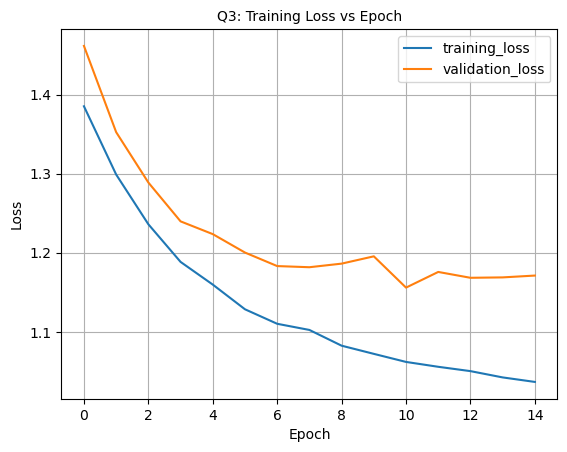

In [12]:
"""
Analyze and plot results.
"""
results_df = pd.DataFrame.from_records(results).set_index('i')
print(results_df)

# plot figure
results_df.plot(
    xlabel="Epoch",
    ylabel="Loss",
    grid=True,
)
plt.title("Q3: Training Loss vs Epoch", fontsize=10)
plt.savefig(f"./figures/{"q3_losses"}.png")

In [17]:
"""
Custom building image test.
"""
def custom_test(img_path, net, device):
    # load & normalize image file
    img = Image.open(img_path)
    img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
    images = torch.FloatTensor(np.array([img]))
    
    # predict image labels
    with torch.no_grad():
        net = net.eval()
        images = images.to(device)
        # output = net(images)
        output = net(images)[0].cpu().numpy()
        c, h, w = output.shape
        assert(c == N_CLASS)
        y = np.zeros((h,w)).astype('uint8')
        for i in range(N_CLASS):
            mask = output[i]>0.5
            y[mask] = i
        save_label(y, './part3/output.png')

# run
custom_test(
    img_path="./part3/input.jpg",
    net=net,
    device=device
)